In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

#import wandb
#from wandb.keras import WandbCallback
#wandb.login()

#run = wandb.init(project="basic-nn-tensorflow", id="lr-scheduler-adam-bce-cos-deeper")
#wandb.config.update(config)

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


['config.ini']

In [10]:
data_path = 'Data/raw-img'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [11]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    validation_split=0.2)

train_data = data_generator.flow_from_directory(
    data_path,
    target_size=(256,256),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training')

valid_data = data_generator.flow_from_directory(
    data_path,
    target_size=(256,256),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='validation')

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


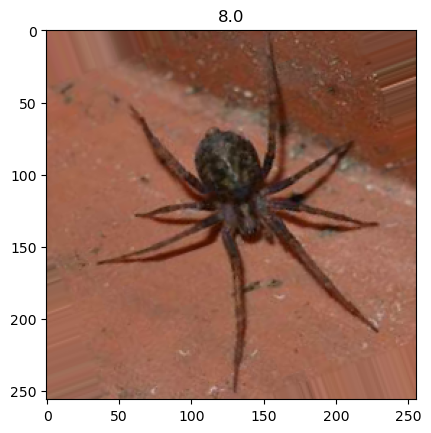

In [12]:
for images, labels in iter(train_data):
    plt.imshow(images[20])
    plt.title(labels[20])
    break

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), input_shape=(256, 256, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 128)     295040    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 64)      

In [20]:
model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50


2023-04-02 16:39:07.824140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


: 

: 